<a href="https://colab.research.google.com/github/Bhavya171/LLM_From_Scratch/blob/main/Chapter_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 6

In [1]:
!git clone https://github.com/Bhavya171/LLM_From_Scratch

Cloning into 'LLM_From_Scratch'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 74 (delta 31), reused 4 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (74/74), 2.11 MiB | 7.60 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
%cd LLM_From_Scratch

/content/LLM_From_Scratch


In [3]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.1 MB/s eta 0:00:00


In [4]:
import urllib.request
import zipfile
import os
from pathlib import Path
import pandas as pd

import tiktoken


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from gpt_download import download_and_load_gpt2
from previous_chapters import GPTModel, load_weights_into_gpt

## Preparating the dataset

Dataset preparation contains 3 steps:

1.   Dataset Prep
2.   Model Setup
3. Model fine tuning and usage



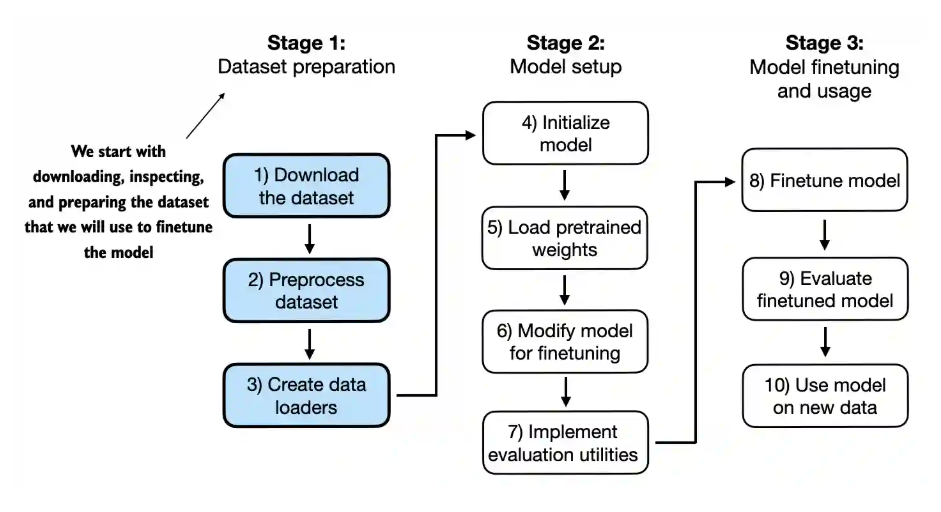

Downloading and unzipping the data

In [5]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (urllib.error.HTTPError, urllib.error.URLError, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [6]:
df  = pd.read_csv(data_file_path, sep = '\t', header = None, names = ["Label", "Text"] )

In [7]:
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [8]:
df['Label'].value_counts()

,count
Label,
ham,4825
spam,747


For simplicity, we can subsample the dataset such that it contains only 747 instances of each type

In [9]:
def create_balanced_dataset(df):
  num_spam = df[df['Label'] == "spam"].shape[0]

  ham_subset = df[df['Label'] == "ham"].sample(num_spam, random_state = 123)

  balanced_df = pd.concat([ham_subset, df[df['Label'] == "spam"]])

  return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df['Label'].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [10]:
balanced_df['Label'] = balanced_df['Label'].map({"ham": 0, "spam":1})

In [11]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [12]:
balanced_df['Label'].value_counts()

,count
Label,
0,747
1,747


Now splitting the dataset into training validation and testing dataset in 70, 10, 20% resp.


In [13]:
def random_split(df, train_frac, validation_frac):
  df = df.sample(frac = 1, random_state = 123).reset_index(drop = True)

  train_end = int(len(df) * train_frac)
  validation_end = train_end + int(len(df) * validation_frac)

  train_df = df[:train_end]
  validation_df = df[train_end:validation_end]
  test_df = df[validation_end:]

  return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("train.csv", index = None)
validation_df.to_csv("validation.csv", index = None)
test_df.to_csv("test.csv", index = None)



## Creating Dataloader

Note that the messages which we will send are of different lengths and if we want to include mupltiple messages in a single batch we have 2 options:

1. Reduce the length of all to match the shortest one
2. Pad all the messages to match to longest one

Choosing option 2 makes much more sense so we pad everything

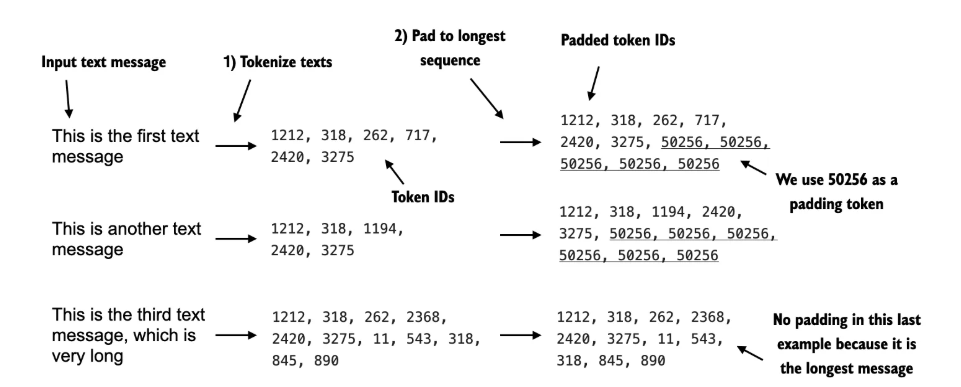

In [14]:
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [15]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # Pre-tokenize texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # Truncate sequences
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to the longest sequence
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0

        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [16]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)


120


In [17]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [18]:
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)


In [19]:
# cross verifying that each batch contains 8 text messages of 120 tokens each

print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)


Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


The total number of batches in each of the datasets

In [20]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")


130 training batches
19 validation batches
38 test batches


So, we have 130 training batches containing 8 messages each of 120 tokens each similiarly 19 validation batches and 38 test batches of the same dimensions

## Initializing a model with pretrained weights

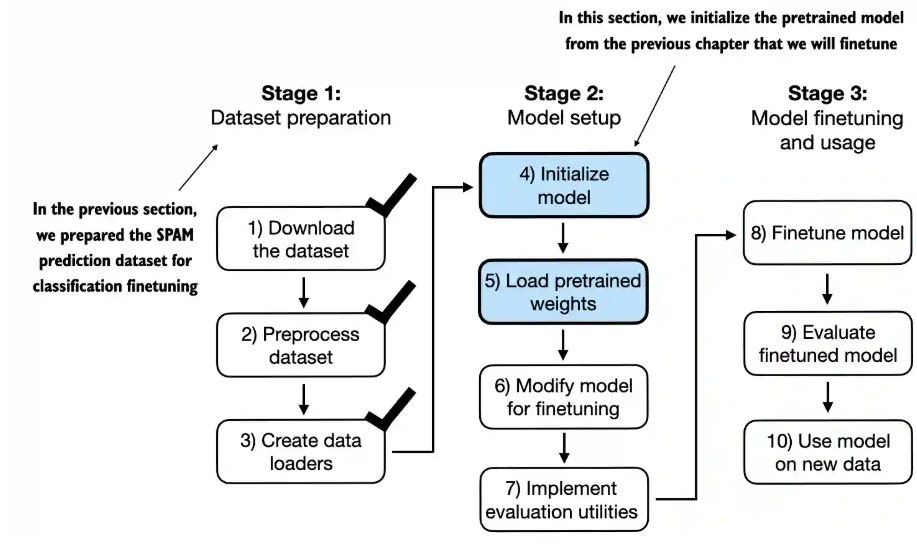

Here we are using the same model which we used earlier

In [21]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# using assert to check that the max length is not greater the the context length if yes then raise error

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [22]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();


checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 102kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 5.47MiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 35.7kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [00:22<00:00, 21.7MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 6.70MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:00<00:00, 3.27MiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 3.11MiB/s]


In [23]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)

text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))


Every effort moves you forward.

The first step is to understand the importance of your work


In [24]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))


Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## Adding a classification head

In [25]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

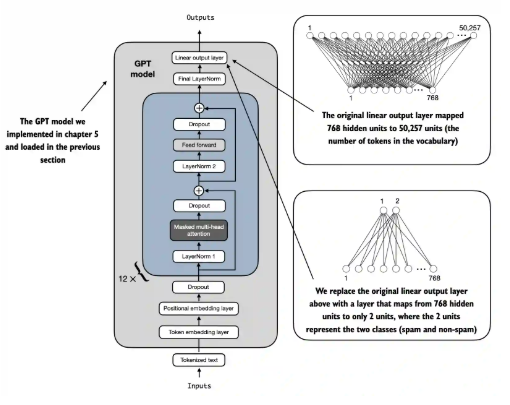

We have to train the final output layer and nothing else. Earlier the output layer had 50k output dimensions which was the vocabulary size but now we only have 2 classes aas the poutput so we will adjust it accordingly.

For that we first freeze the model so that other layers remain unchanged.

In [26]:
for param in model.parameters():
    param.requires_grad = False


In [27]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

Training the output layer only should suffice but training the final transformer block increases the performance drastically.



In [28]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

We can still use the model fo rthe previous functionalities

In [29]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)


# the only change is the output size which is 2 now


Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [30]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [31]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


## Calculating the classification loss and accuracy